<a href="https://colab.research.google.com/github/dcolinmorgan/test/blob/master/forecast_lstm_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

!pip install chart_studio
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
from datetime import timedelta
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    plt.grid(True)

In [9]:
f = pdr.DataReader('ticker=RGDPUS', 'econdb')
today=dt.datetime.today().strftime("%Y-%m-%d")
thirtyya=str(int(str(today).split('-')[0])-30)+'-'+str(today).split('-')[1]+'-'+str(today).split('-')[2]

<Figure size 432x288 with 0 Axes>

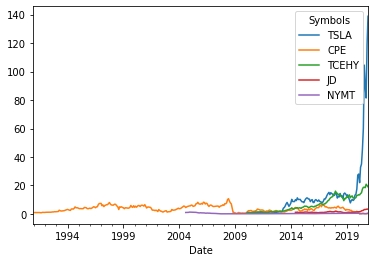

In [10]:
portfolio = ['TSLA','CPE','TCEHY','JD','NYMT']#"UCO","NYMT", "SPOT", "TWTR","NCLH",'SAVE',"SNAP",'PLTR',"IQ",'NIO','EUFN']#,'DBX','FLXN','ZNGA','OCUL','WEAT','CLDR','SPWR','NRGU','IPOB','VKTX']
multpl_stocks = pdr.get_data_yahoo(portfolio,
start = thirtyya,
end = today)
multpl_stock_daily_returns = multpl_stocks['Adj Close'].pct_change()
multpl_stock_monthly_returns = multpl_stocks['Adj Close'].resample('M').ffill().pct_change()
fig = plt.figure()
(multpl_stock_monthly_returns + 1).cumprod().plot()
plt.show()


In [181]:

portfolio = ['NYMT']#'TCEHY','JD','NYMT']#"UCO","NYMT", "SPOT", "TWTR","NCLH",'SAVE',"SNAP",'PLTR',"IQ",'NIO','EUFN']#,'DBX','FLXN','ZNGA','OCUL','WEAT','CLDR','SPWR','NRGU','IPOB','VKTX']
stock_data = pdr.get_data_yahoo(portfolio,
start = thirtyya,
end = today,)
stock_data=stock_data[['Open', 'High', 'Low', 'Volume', 'Close']]

base = dt.datetime.today()
date_list = [base + dt.timedelta(days=x) for x in range(90)]
date_list=pd.DataFrame(date_list,columns=['AB'])
date_list['AB']=date_list['AB'].astype(str)
date_list[['A', 'B']] = date_list['AB'].str.split(' ', 1, expand=True)
del date_list['AB'], date_list['B']
d = pd.DataFrame(0, index=date_list[1:]['A'], columns=stock_data.columns)
d.index=pd.DatetimeIndex(d.index)
stock_data=stock_data.append(d)
stock_data=stock_data[::-1]
# y=y[::-1]
input_feature = stock_data[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values


scaler = MinMaxScaler(feature_range=(0,1))
input_data = scaler.fit_transform(stock_data)




In [182]:
# stock_data.index.str.split('       ')#[1]
# stock_data.index.str.split('00:00:00')
stock_data['Date']=stock_data.index
stock_data.columns=['Open','High','Low','Volume','Close','Date']
# stock_data=stock_data.reset_index
stock_data.reindex(index=stock_data.index[::-1])
stock_data.reset_index(inplace=True)
del stock_data['index']
stock_data

,Open,High,Low,Volume,Close,Date
0,0.000000,0.000000,0.000000,0.0,0.000000,2021-03-26
1,0.000000,0.000000,0.000000,0.0,0.000000,2021-03-25
2,0.000000,0.000000,0.000000,0.0,0.000000,2021-03-24
3,0.000000,0.000000,0.000000,0.0,0.000000,2021-03-23
4,0.000000,0.000000,0.000000,0.0,0.000000,2021-03-22
...,...,...,...,...,...,...
4220,87.500000,87.599998,87.000000,8000.0,87.400002,2004-07-30
4221,88.400002,89.000000,88.000000,1300.0,88.500000,2004-07-29
4222,88.500000,88.699997,88.300003,1200.0,88.599998,2004-07-28
4223,89.199997,89.199997,88.500000,900.0,88.699997,2004-07-27


In [183]:
stock_data.reindex(index=stock_data.index[::-1])

df2=stock_data[['Date','Close']]
df2.index=df2['Date']
del df2['Date']
df2=df2[89:]
df2=df2[::-1]

In [388]:
train = df2
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
n_input = 61
n_features = 1
generator = TimeseriesGenerator(train,train,sampling_rate=1, length=n_input, batch_size=6)

# train_x=train[0:2999]
# train_y=train[3000:5999]
train_x=train[:-366]
train_y=train[-366:]

training_sequence = TimeseriesGenerator(train_x, train_x,sampling_rate=1, length=n_input, batch_size=6)
validation_sequence = TimeseriesGenerator(train_y, train_y,sampling_rate=1, stride=30, length=n_input, batch_size=6)

In [412]:
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=3, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [393]:
import keras
from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda

model = Sequential()
# model.add(Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",
#                  activation="relu",input_shape=[n_input, n_features])),
model.add(LSTM(200, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
# model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))

model.add(Bidirectional(LSTM(20, activation='relu'))),

# model.add(LSTM(50)),
model.add(Dropout(0.15)),
model.add(Dense(1))


# optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
# model.compile(loss='tf.keras.losses.Huber()',optimizer=optimizer,metrics=["mae"])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse',metrics=[['accuracy', 'mse']])

In [394]:
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 61, 200)           161600    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 40)                35360     
_________________________________________________________________
dropout_43 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 41        
Total params: 197,001
Trainable params: 197,001
Non-trainable params: 0
_________________________________________________________________


In [395]:
# history = model.fit_generator(generator,epochs=100,callbacks=callbacks,verbose=1)
history =model.fit_generator(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)

# history =model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)


Epoch 1/100
619/619 [==============================] - 67s 103ms/step - loss: 0.0595 - accuracy: 0.0000e+00 - mse: 0.0595 - val_loss: 7.3349e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.3349e-04

Epoch 00001: val_loss improved from inf to 0.00073, saving model to model.h5
Epoch 2/100
619/619 [==============================] - 63s 102ms/step - loss: 0.0628 - accuracy: 0.0000e+00 - mse: 0.0628 - val_loss: 5.5107e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.5107e-04

Epoch 00002: val_loss improved from 0.00073 to 0.00055, saving model to model.h5
Epoch 3/100
619/619 [==============================] - 63s 102ms/step - loss: 0.0544 - accuracy: 0.0000e+00 - mse: 0.0544 - val_loss: 4.1647e-04 - val_accuracy: 0.0000e+00 - val_mse: 4.1647e-04

Epoch 00003: val_loss improved from 0.00055 to 0.00042, saving model to model.h5
Epoch 4/100
619/619 [==============================] - 64s 103ms/step - loss: 0.0593 - accuracy: 0.0000e+00 - mse: 0.0593 - val_loss: 3.1171e-04 - val_accuracy: 0.0000e+00 - va

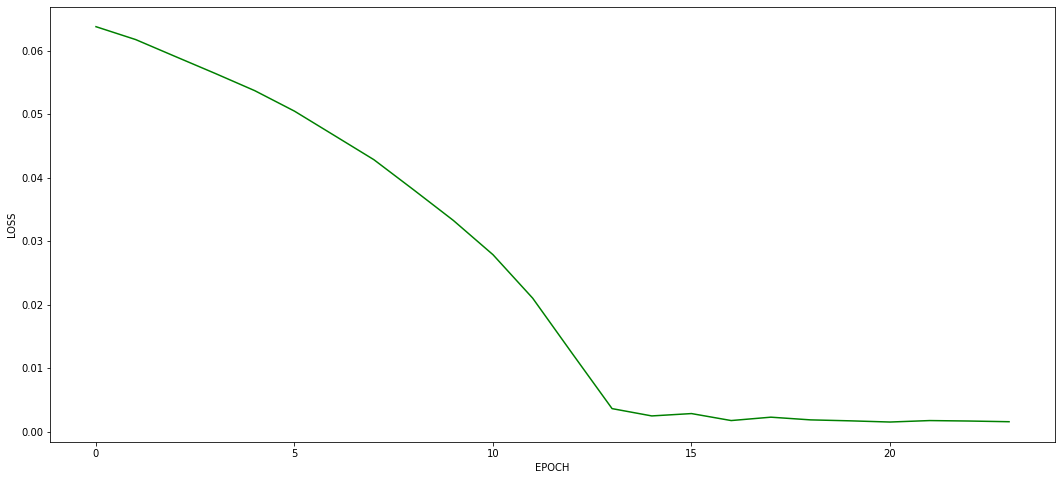

In [396]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.show()


In [407]:
# df2=df2[::-1]
# train = np.array(pd.DataFrame(train_y).append(pd.DataFrame(train_x)))
# train=train[::-1]
train = df2

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

# scaler = MinMaxScaler()
# scaler.fit(train)
# train = scaler.transform(train)

In [408]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [409]:
add_dates = [df2.index[-1] + DateOffset(days=x) for x in range(0,n_input+1) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df2.columns)

In [410]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])
# df_predict=df_predict[::-1]
df_proj = pd.concat([df2,df_predict], axis=1)

df_proj.tail(12)

,Close,Prediction
2022-12-15,NaN,4.584336
2022-12-16,NaN,4.599943
2022-12-17,NaN,4.615625
2022-12-18,NaN,4.636254
2022-12-19,NaN,4.658004
2022-12-20,NaN,4.677357
2022-12-21,NaN,4.708554
2022-12-22,NaN,4.744743
2022-12-23,NaN,4.795895
2022-12-24,NaN,4.855490


In [414]:
df_proj

,Close,Prediction
2004-07-26,89.599998,NaN
2004-07-27,88.699997,NaN
2004-07-28,88.599998,NaN
2004-07-29,88.500000,NaN
2004-07-30,87.400002,NaN
...,...,...
2022-12-22,NaN,4.744743
2022-12-23,NaN,4.795895
2022-12-24,NaN,4.855490
2022-12-25,NaN,4.930103


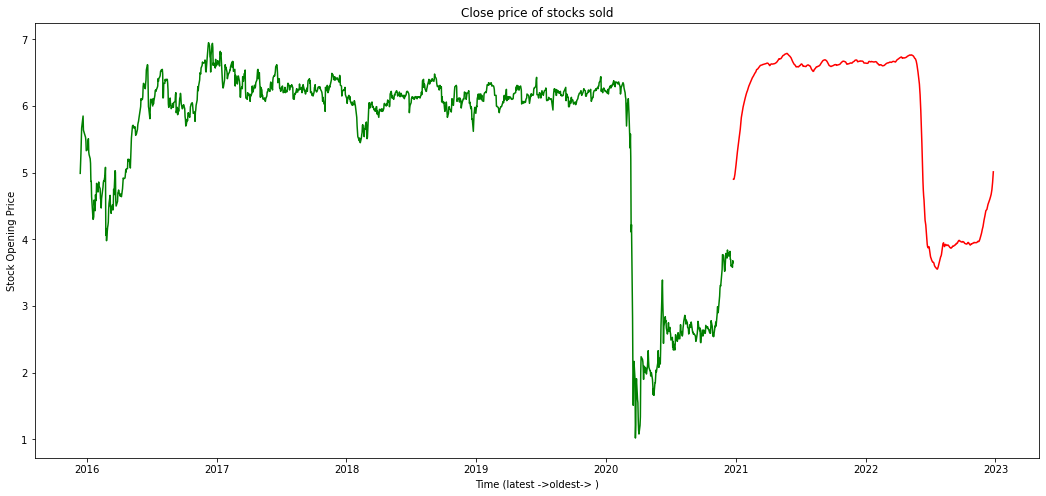

In [416]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(df_proj['Close'][-2000:], color= 'green')
plt.plot(df_proj['Prediction'][-2000:], color='red')
plt.title("Close price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Opening Price")
plt.show()
